## 1. Load & Preprocess Dataset (32x32 grayscale)

Adjust `DATASET_PATH` to point to your extracted dataset folder (which contains one subfolder per class).

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter


DATASET_PATH = "./animal_dataset" 
IMG_SIZE = (32, 32)

def load_images(folder):
    X = []
    y = []
    class_names = sorted([d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))])
    for label, cls in enumerate(class_names):
        cls_path = os.path.join(folder, cls)
        print(cls_path)
        for img_name in sorted(os.listdir(cls_path)):
            img_path = os.path.join(cls_path, img_name)
            try:
                img = Image.open(img_path).convert("L").resize(IMG_SIZE)
                X.append(np.array(img).flatten())
                y.append(label)
            except Exception as e:
                # skip unreadable files but print a message
                print(f"skipping {img_path}: {e}")
    return np.array(X), np.array(y), class_names


X, y, class_names = load_images(DATASET_PATH)
print('X.shape =', X.shape)
print('y.shape =', y.shape)
print('classes =', class_names)

./animal_dataset/cat
./animal_dataset/dog
./animal_dataset/panda
X.shape = (300, 1024)
y.shape = (300,)
classes = ['cat', 'dog', 'panda']


## 2. Distance Functions (Manhattan & Euclidean)

In [2]:
def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

## 3. KNN Classifier (From Scratch)

In [3]:
def knn_predict(sample, X_train, y_train, k, distance_fn):
    # compute distances
    dists = [(distance_fn(sample, x), y_train[i]) for i, x in enumerate(X_train)]
    dists.sort(key=lambda x: x[0])
    topk = [label for _, label in dists[:k]]
    return Counter(topk).most_common(1)[0][0]

## 4. 5-Fold Cross Validation

In [4]:
def cross_validation(X, y, k_values, distance_fn, folds=5, seed=1):
    np.random.seed(seed)
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    Xs = X[idx]
    ys = y[idx]
    fold_size = len(X) // folds
    accuracies = {k: [] for k in k_values}
    for f in range(folds):
        s = f * fold_size
        e = s + fold_size if f < folds - 1 else len(X)
        X_val = Xs[s:e]
        y_val = ys[s:e]
        X_train = np.concatenate([Xs[:s], Xs[e:]]) if s>0 or e<len(X) else Xs[s:e]
        y_train = np.concatenate([ys[:s], ys[e:]]) if s>0 or e<len(X) else ys[s:e]
        for k in k_values:
            correct = 0
            for i in range(len(X_val)):
                pred = knn_predict(X_val[i], X_train, y_train, k, distance_fn)
                if pred == y_val[i]:
                    correct += 1
            accuracies[k].append(correct / len(X_val))
    return {k: np.mean(v) for k, v in accuracies.items()}

## 5. Evaluate L1 vs L2 & Plot

Run cross-validation for a range of K values and compare accuracies.

Running 5-fold CV (this can take time)...
L1 accuracies: {1: 0.4066666666666666, 3: 0.4333333333333334, 5: 0.43, 7: 0.44666666666666666, 9: 0.42000000000000004}
L2 accuracies: {1: 0.33333333333333337, 3: 0.3433333333333333, 5: 0.37333333333333335, 7: 0.4066666666666666, 9: 0.4066666666666666}


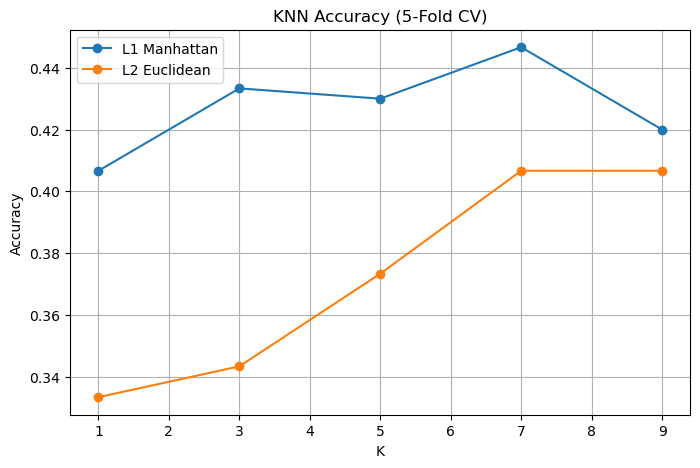

In [5]:
k_values = [1, 3, 5, 7, 9]
print('Running 5-fold CV (this can take time)...')

acc_L1 = cross_validation(X, y, k_values, manhattan_distance)
acc_L2 = cross_validation(X, y, k_values, euclidean_distance)

print('L1 accuracies:', acc_L1)
print('L2 accuracies:', acc_L2)

plt.figure(figsize=(8,5))
plt.plot(k_values, [acc_L1[k] for k in k_values], marker='o', label='L1 Manhattan')
plt.plot(k_values, [acc_L2[k] for k in k_values], marker='o', label='L2 Euclidean')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy (5-Fold CV)')
plt.legend()
plt.grid(True)
plt.show()

## 6. Top-5 Predictions

Show the top-5 nearest neighbors for a sample image.

In [6]:
def top_5_predictions(sample, X_train, y_train, distance_fn):
    d = [(distance_fn(sample, X_train[i]), y_train[i]) for i in range(len(X_train))]
    d.sort(key=lambda x: x[0])
    return [(i+1, class_names[label]) for i, (_, label) in enumerate(d[:5])]

# Example: show top-5 for first image (avoid using the image itself in training)
if len(X) > 1:
    example = X[0]
    neighbors = top_5_predictions(example, X[1:], y[1:], euclidean_distance)
    print('Top-5 neighbors (rank, class):')
    for rank, cls in neighbors:
        print(rank, cls)

Top-5 neighbors (rank, class):
1 cat
2 panda
3 dog
4 cat
5 cat


## 7. Discussion

- **Which metric is better?** Compare the printed accuracies and plot. Consider dataset sparsity and feature scale.
- **Limitations:** KNN scales poorly with dataset size; raw pixels may be insufficient features.
- **Improvements:** PCA, feature extraction (HOG), or using a small CNN; implement KD-trees for speed.